# Multivariate analysis

1. Definining the model: why we chose for Bayesian model and how we implemented it
1. Technical diagnostics: did the model work
1. Functional diagnostics: do the paramter estimates make sense
1. Prediction
1. Prediction Quality

## Defining the model
* Why Bayesian models (https://www.pymc-labs.io/blog-posts/saving-the-world/)
(http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/)

### A Bayesian model is the most appropriate for this kind of data
Now that we have the data in hand and understand the data, we set off to build a multivariate model. While many types of models exist, we choose to use a **Bayesian model**, for 4 reasons:

#TODO before diving into this, let's first _quickly_ explain Bayesian modeling. 
1. Bayesian model have **easy interpretation**.
Firstly, our goal of the exercise is not necessarily to predict new boosts (although we will be able to do that well too, see point 2), but to infer which parameters affect the boost. While many - many - methods exist to make Machine Learning models more explainable, and there is a lot of great work done in that area, from a philosophical point of view it makes sense to choose a model where the intepretability comes naturally, instead of fitting a complex neural network and then putting in the effort to make that explainable. A personal preference is that I like that the uncertainty in an estimate and a parameter value comes very naturally. In terms of interpretation, I have also found that the interpretation of the the posterior comes more natural to people than the interpretaton of Maximum Likelihood Estimate

1. Bayesian models deal with **small datasets** very well. 
In the case at hand, we have only 153 rows, from only 63 distinct artists. Machine Learning models may be trained on thousands if not hundreds of thousands or millions of samples, and may overfit for small datasets. Of course, we can regularize the models, but the balance would be fragile and we could easily end up either overfitting or underfitting. By specifying _priors_ (our knowledge/beliefs before we have looked at the data), the model does not have to learn everything from the data and needs much less data.

1. Very naturally deals with the **hierarchy in this data set**. That immediately brings us to our next point. This data set has a strong hierarchy in it: there are 63 artist, who each have 1 or more songs. We could of course just duplicate artist properties to each song, but that would easily get us into trouble of being overconfident in our estimates, and weighing the input of Michael Jackson more heavily than the input of an artist who only occurred in the Top 2000 once. While that is reasonable on song characteristics, it is not reasonable on artist characteristics and would definetly result in spurious correlations. A Bayesian model very naturally allows us to specify the effect artist characteristics may have on an artist boost, and the nhow an artist boost influences a song boost

1. **Scales very well** to more complex models. One of the great things about Bayesian Models from a technical point of view is that there is just one way to do Bayesian modelling: you specify a model with priors, you run the MCMC sampling algorithm, and you have everything: predictions, parameter estimates, etc. With Machine Learning, you have to choose between dozens of algorithms, transformers, selectors, hyperparameters, and so on. The initial set up of a Bayesian model is more time consuming than its corresponding frequentist Machine Learning algorithm - but the upside is that you're done and that there's a straight path ahead once you've overcome that first hurdle of specifying a model with priors: use the posterior distribution to calculate any quantity of interest.

### We specify the model based on our hypotheses
Now that we have chosen to model according to a Bayesian model, we must specify our model. We incorporate the following effects, and specify a prior, aided by the [recommendations of the Stan development team](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations):
&nbsp; &nbsp; &nbsp;

|Level| Effect name| Operationalisation | Prior | Comments
|-----| ----------- | ------------------ | ----- | --------
|**Base**| Base&nbsp;effect |                    |N(0,2) | Weakly informative; absolute effect smaller than $\exp(4) \approx 55$ times
|**Base**| Historical&nbsp;effect |              | N(0,0.05) | Weakly informative; absolute effect over 20 years smaller than $\exp(20*0.05*2)=\exp(2) \approx 7.3$ times
|**Artist**| Artist&nbsp;popularity | Taking the logarithm of the percentage of the votes an artist got in the year before his/her death. We subtract the median from this to have a more readily interpretatable quality | N(0.5,2) | Weakly informative
|**Artist**| Recency&nbsp;&nbsp;exponent | The shape of the exponential of the rececy effect, where a smaller exponent means the effect is more gradual. #TODO: Explain why we subtract 365 days | N(-1.5,1) | Based on a [paper](https://www.researchgate.net/publication/337320973_Music_Death_and_Profits_Variables_Contributing_to_the_Surge_in_Sales_After_an_Artist's_Death), but widened a bit
|**Artist**| Max&nbsp;recency&nbsp;effect | The height of the exponential of the recency effect | N(2,2) | Weakly informative
|**Artist**| Dutch | 1 if an artist is Dutch | N(0,2) | Weakly informative
|**Artist**| Artist&nbsp;age | By counting the years an artist passed before his/her 80th birthday. We expect there is more news when an artist dies young, but there should not be a noticeable difference between 83 and 89, for instance | N(0,0.01) | Weakly informative; artist who passes aged 20 to have a maximum extra boost of $\exp(60 * 0.01 * 2) = \exp(1.2) \approx 3.3$.
|**Artist**| Artist-specific&nbsp;effect | A parameter for every artist that allows the artist to get a smaller or larger boost than expected purely | N(0, 1) | 
|**Song**| Within&nbsp;oeuvre&nbsp;effect | We have to be careful that it does not duplicate the artist popularity's parameter. Therefore, we divide the percentage of votes of a song by the average of the artist's song's percentage, so they are not correlated.|N(0,2) | Weakly informative
|**Song**| Multiple&nbsp;performers | When a song was performed by 2 or more artists | N(0,2) | Weakly informative


#TODO Explain the working, ideally based on a figure

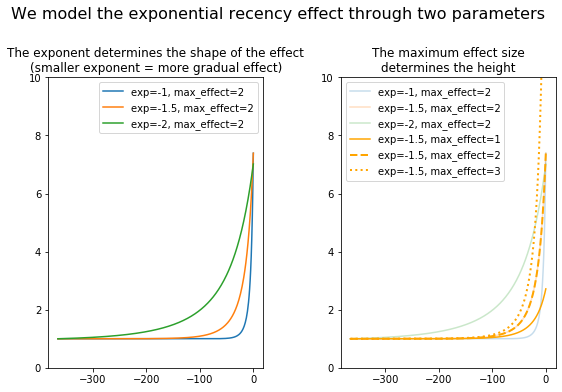

In [64]:
def calculate_recency_effect(recency_exponent=-1.5, max_recency_effect=2, days_to_votingperiod=np.arange(-365, 1)):
    result = np.exp(10**recency_exponent * days_to_votingperiod) - np.exp(10**recency_exponent * min(days_to_votingperiod))
    name = f'exp={recency_exponent}, max_effect={max_recency_effect}'
    return pd.Series(np.exp(result * max_recency_effect), index=days_to_votingperiod, name=name)

fig, axes = plt.subplots(1, 2, figsize=(8, 5))
pd.concat([calculate_recency_effect(recency_exponent=r) for r in [-1, -1.5, -2]],
          axis='columns'
         ).plot(ylim=(0, 10), ax=axes[0])

pd.concat([calculate_recency_effect(recency_exponent=r) for r in [-1, -1.5, -2]],
          axis='columns'
         ).plot(ylim=(0, 10), alpha=0.25, ax=axes[1])
calculate_recency_effect(max_recency_effect=1).plot(ax=axes[1], c='orange', ls='-')
calculate_recency_effect(max_recency_effect=2).plot(ax=axes[1], c='orange', ls='--', lw=2)
calculate_recency_effect(max_recency_effect=3).plot(ax=axes[1], c='orange', ls= ':', lw=2)
plt.suptitle('We model the exponential recency effect through two parameters', fontsize=16, y=1.08)
axes[0].set_title('The exponent determines the shape of the effect\n(smaller exponent = more gradual effect)')
axes[1].set_title('The maximum effect size\ndetermines the height')
plt.legend()
plt.tight_layout()
plt.show()    

### We implement the Bayesian Model in PyMC3
While there are many great packages to run Markov Chains Monte Carlo (MCMC) in Python, I'm a fan of the [`PyMC3` package](https://docs.pymc.io/), and this model is inspired by, and partly follows the documentation's primer on [multilevel modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html), which I highly recommend.
I think one of the great aspects about `PyMC3` is that it combines state-of-the-art performance, with wide functionaltity and distribution availability, with an intuitive API that makes probabilistic programming relatively easy.

The first thing we do is set up a "model factory", which is a function that returns a `PyMC3`-model. We can then use this model we within a context manager to do everything we want: sample from the prior distribution, the posterior distribution, etc.

Within the model, we specify both the effects and the priors, as we defined above. Specificaly, we pay attention to the following things:
- We use the non-centered version of a model, which is just a mathematical trick to make the sampling more robust; see [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for more information. 
- We make the artist boost Deterministic variables. We could just as easily have not did that, but this allows us to inspect the variables after the sampling, since they will be included in the InferenceData-object.
- The [InferenceData object](https://arviz-devs.github.io/arviz/schema/schema.html) is the object returned which contains all information one could possibly need, such as the priors, the posterios, the observed data, the constant data, and so forth. The fact that this is all recorded in one object, makes diagnosing, investigating and visualizing both the sampling and the outcomes very easy, through the great [`arviz` package](https://arviz-devs.github.io/arviz/index.html).
- A final thing that we include are [_dimensions_ and _coordinates_](https://oriolabril.github.io/oriol_unraveled/python/arviz/pymc3/xarray/2020/09/22/pymc3-arviz.html). That is metadata that the model uses for combining data and parameters. For instance, in the coordinates we specify which song belongs to which artist, so the model can apply the artist boost appropriately. Also, by passing the dimensions to each parameter, it automatically decides how many parameters it needs (e.g. one artist specific parameter for each artist). And the cherry on the top is that thos dimensions and coordinates will be saved to the grea InferenceData-object, so that we can use it for plotting.

Ok, that was a lot of talking; let's get to building the model. Once we have specified it, we can immediately sample from it to get the posterior distributions.

In [65]:
RANDOM_SEED = 42
def model_factory(X, y):
    passed_away_artists = X['ArtistID'].unique()
    # TODO: explain this is for indexing
    artist_lookup = {artist_id: i for i, artist_id in enumerate(X['ArtistID'].unique())}
    artist_vals = X['ArtistID'].replace(artist_lookup).values
    artist_model = (X.assign(ArtistIDModel = lambda df: X['ArtistID'].map(artist_lookup),
                             )
                .sort_values('ArtistIDModel')
                .drop_duplicates(['ArtistIDModel'])
               )
    
    
    coords = {"obs_id": np.arange(X.shape[0]),
              'Artist': range(len(passed_away_artists)) # TODO: check what this does exactly
         }
    for key, values in coords.items():
        if len(set(values)) <= 1:
            raise ValueError(f'PyMC3 requires at least two unique values per coordinate, {key} has less: {set(values)}')
    
    with pm.Model(coords=coords) as model:
        artist_idx = pm.Data("artist_idx", artist_vals, dims="obs_id")
        days_to_stemperiode = pm.Data('days_to_stemperiode', artist_model['DaysToStemperiode'], dims='Artist')
        logpopularity = pm.Data('logpopularity', artist_model['LogPopularityNorm'], dims='Artist')
        jaren_geleden = pm.Data("jaren_geleden", artist_model['JarenGeleden'], dims='Artist')
        passing_too_early = pm.Data('passing_too_early', artist_model['PassingTooEarly'], dims='Artist')
        is_dutch = pm.Data('is_dutch', artist_model['IsDutchArtist'], dims='Artist')

        multiple_performers = pm.Data('multiple_performers', X['MultiplePerformers'], dims="obs_id")
        popularity_within_oeuvre = pm.Data('popularity_within_oeuvre', X['LogSongPopularityWithinArtist'], dims="obs_id")

        # Hyperpriors:
        a = pm.Normal("a", mu=0, sigma=2.0)
        sigma_a = pm.Exponential("sigma_a", 1.0)

        recency_effect_exponent = pm.Normal('recency_effect_exponent', mu=-1.5,sigma=1)
        max_recency_effect = pm.Normal('max_recency_effect', mu=2, sigma=2)
        effect_popularity = pm.Normal('effect_popularity', mu=0.5, sigma=2)
        history_effect = pm.Normal('history_effect', mu=0, sigma=0.05)
        age_passing_effect = pm.Normal('age_passing_effect', mu=0.01, sigma=0.05)
        is_dutch_effect = pm.Normal('is_dutch_effect', mu=0, sigma=2)

        # Expected value per artist:
        mu_artist = (a
                     + logpopularity * effect_popularity
                     # The correction of subtracting the minimum value breaks the degeneracy between _a_ and the recency effect
                     # It is important for two reasons:
                     # 1. It makes sampling much more stable
                     # 2. It allows for much easier interpretation of the recency effect
                     + (np.exp(10**recency_effect_exponent * days_to_stemperiode)- np.exp(10**recency_effect_exponent * -365))* max_recency_effect
                     + jaren_geleden * history_effect
                     + passing_too_early * age_passing_effect
                     + is_dutch * is_dutch_effect
                    )

        # This is the non-centered version of the model for a much more stable sampling
        # See https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/ for more information
        # By making mu_artist and a_artist a pm.Deterministic, we can still access them via the InferenceData, but it is not strictly necessary
        mu_artist = pm.Deterministic("mu_artist", mu_artist, dims="Artist")
        za_artist = pm.Normal("za_artist", mu=0.0, sigma=1.0, dims='Artist')
        a_artist = pm.Deterministic("a_artist", mu_artist + za_artist * sigma_a, dims="Artist")
        sharing_effect = pm.Normal('sharing_effect', mu=0, sigma=2.0)
        within_oeuvre_effect = pm.Normal('within_oeuvre_effect', mu=0, sigma=2.0)
        theta = (a_artist[artist_idx]
                 + multiple_performers * sharing_effect
                 + popularity_within_oeuvre * within_oeuvre_effect
                )
        # Model error:
        sigma = pm.Exponential("sigma", 1.0)
        y_like = pm.Normal("y_like", theta, sigma=sigma, observed=y, dims="obs_id")
        
        return model

In [66]:
with model_factory(X=df.drop(columns='LogBoost'),
                   y=df['LogBoost'],
                   ) as multilevel_noncentered_model:
#     display(pm.model_to_graphviz(multilevel_noncentered_model))
    multilevel_noncentered_model_idata = pm.sample(10000, tune=3000, return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, within_oeuvre_effect, sharing_effect, za_artist, is_dutch_effect, age_passing_effect, history_effect, effect_popularity, max_recency_effect, recency_effect_exponent, sigma_a, a]


Sampling 2 chains for 3_000 tune and 10_000 draw iterations (6_000 + 20_000 draws total) took 206 seconds.


0, dim: obs_id, 153 =? 153


The number of effective samples is smaller than 25% for some parameters.


## Technical checks of the model run
https://arxiv.org/abs/1701.02434

Now that we've run our model, and have our parameter estimates, it is tempting to just dive right in. But it is paramount that we get some confidence in that the model worked well. Luckily, since the Bayesian workflow is so standard, we can use a number of standard plots to get that intuition.

TODO: insert dartboard

With every model comes a _bias-variance_-trade off:
* __Biased__ estimators occur when the MCMC chains have not _converged_ properly: they did not reach the Typical Set (TODO: explain better). This may have multiple causes, such as a difficult geometry (which may be solved by reparameterizing the model and/or taking smaller steps by increasing the acceptance ratio) or not having enough time to reach from the stationary distribution from the starting point, which can be solved by increasing the number of tuning steps
* __High variance__ occurs when there are not enough effective samples and there is some error left from the random nature of the algorithm. This can come from either having too few samples in general, which is solved by running the chain longer, or having too much autocorrelation, which is solved by taking larger steps by decreasing the acceptance ratio.

In our case, we see there were 0 divergences, which is a good sign for convergence. There is a warning about the effective sample size being smaller than 25%, so possibly we should check wether we do not have too much variance. In the table below, we also see that $\hat{R}$ (r_hat) is much lower than $1.01$ which gives us further confidence. However, indeed we do see that the _Effective Sample Size_ (ess_\*) varies quite a bit.

In [67]:
# Ignore the variables which occur once for every artist, and ignore the sigmas
var_names = [
            '~a_artist',
            '~sigma_a',
            '~sigma',
            '~za_artist',
            '~mu_artist'
            ]


In [68]:
az.summary(multilevel_noncentered_model_idata, kind='diagnostics', var_names=var_names, round_to=4)

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.0012,0.0009,9353.5189,11521.7571,1.0002
recency_effect_exponent,0.0071,0.0056,4587.1919,2237.1336,1.0002
max_recency_effect,0.0065,0.0058,7217.1504,3448.4085,1.0007
effect_popularity,0.0010,0.0007,10716.3110,13665.3531,1.0001
history_effect,0.0001,0.0001,11812.7869,14099.2390,1.0000
age_passing_effect,0.0000,0.0000,12295.8068,12760.4698,1.0000
is_dutch_effect,0.0013,0.0010,11652.9903,12499.5089,1.0003
sharing_effect,0.0007,0.0005,26654.5086,15100.8101,1.0000
within_oeuvre_effect,0.0006,0.0010,39914.2621,14730.2942,1.0000


### Convergence
We diagnose converges both on the level of the run, and on the level of individual parameters. On the level of the run, we will check both the Bayesian Fraction of Missing Information and the number of divergences. On the level of individual parameters, we will look into traceplots and $\hat{R}$.

#### Run convergence

PyMC3 automatically assigned the NUTS-sampler when we were sampling the MCMC. This is a good thing, since NUTS is a state-of-the-art that is both robust and efficient. Specifically, it is a _self-tuning_ Hamiltonian Monte Carlo sampler. With Hamiltonian Monte Carlo samplers, it is always a good idea to check whether the Energy transition distribution matches the marginal energy distribution.
This can be quantified through the _Bayesian Fraction of Missing Information_ (BFMI), which is generally accepted when it is aboven 30%. In our case, it is above 70% for each chain, so this is considered good.

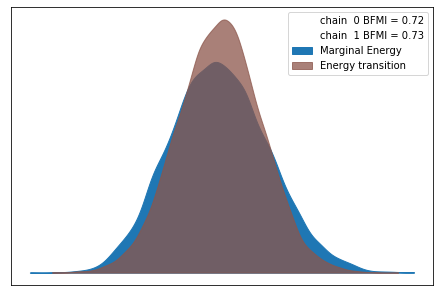

In [69]:
az.plot_energy(multilevel_noncentered_model_idata)
plt.show()

Apart from the _BFMI_, we do not want any _divergences_, which is also the case

In [70]:
multilevel_noncentered_model_idata.sample_stats.to_dataframe()['diverging'].any()

False

#### Individual parameter convergence

Secondly, I always check the trace plot, which should look like a "fuzzy caterpillar"; chains should overlap and should jump around the parameter range, and not get stuck in small areas. In our case, this looks good.

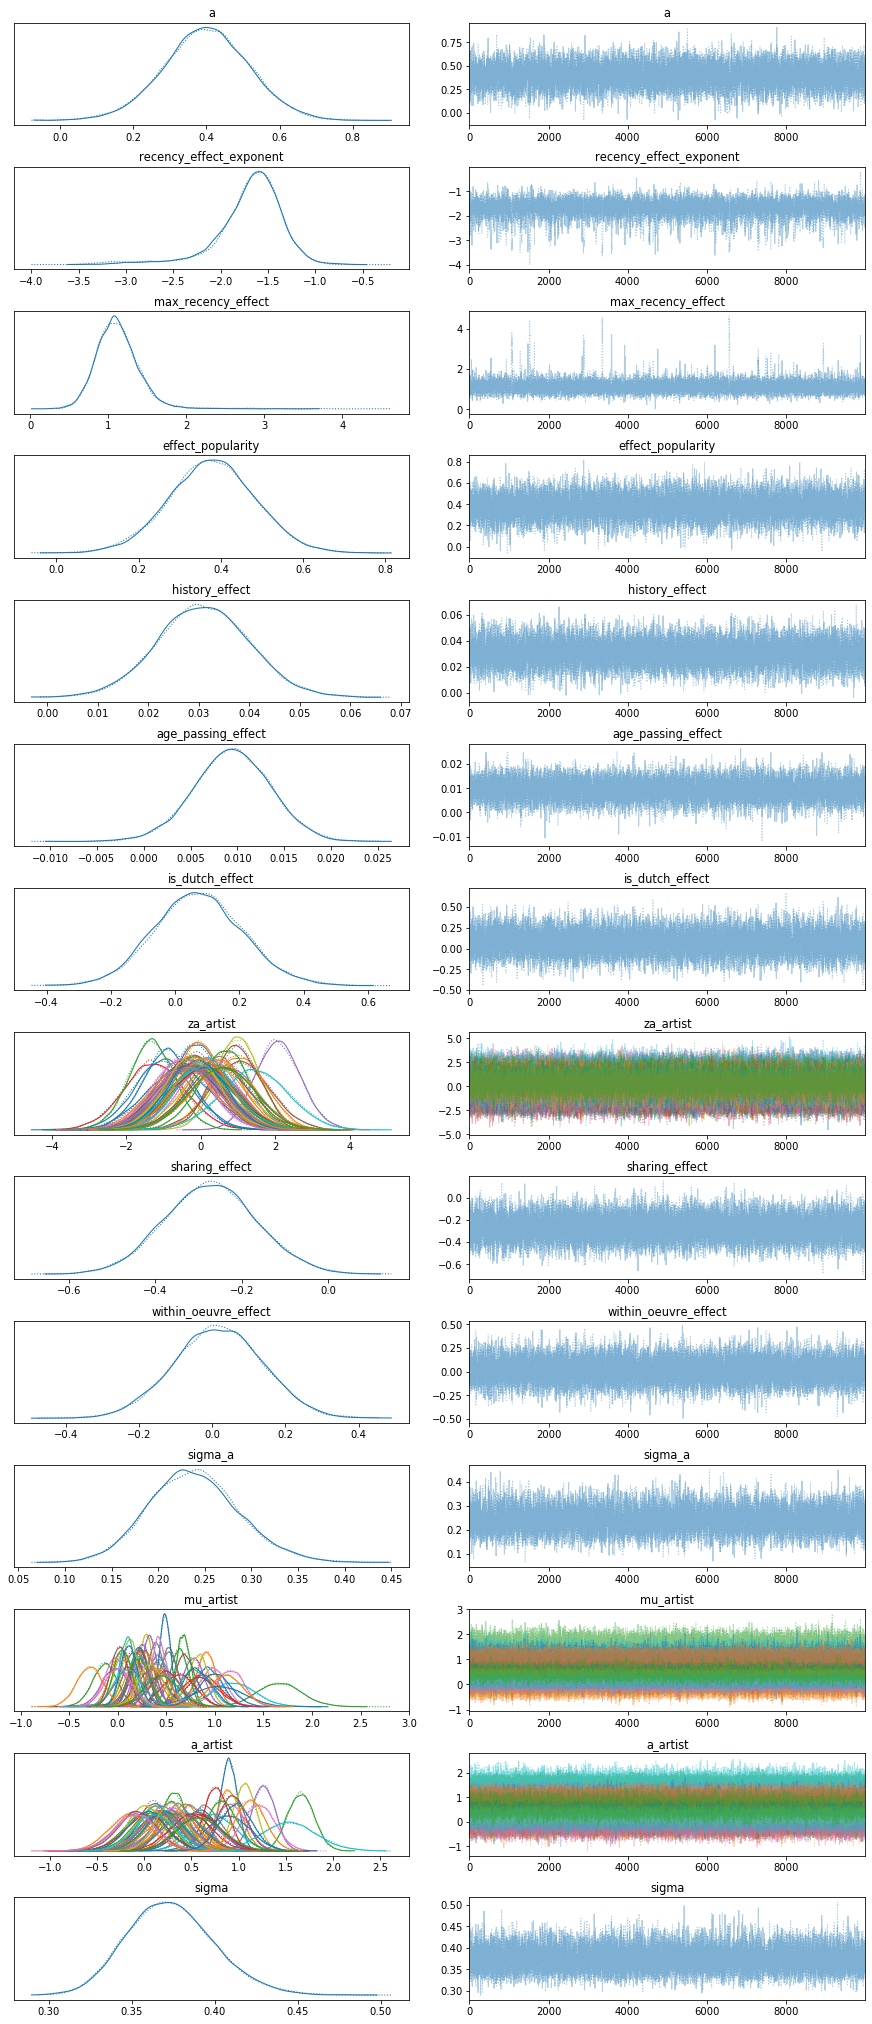

In [71]:
_ = az.plot_trace(multilevel_noncentered_model_idata, compact=True, combined=False)

While trace plots look nice visually,  for a lot of variables it becomes a bit unwieldy; we already see this for $\mu_{\textrm{artist}}$ and $a_{\textrm{artist}}$ where it becomes hard to make out anything.
We can formalize this procedure through a measure known as $\hat{R}$, which basically divides the variance within chains to the the variance between the chains. If chains, which are started at different points, end up exploring the same range, this gives us confidence in convergence. PyMC3 by default uses the improvements suggested by [Vehtari et al. (2019)](https://arxiv.org/abs/1903.08008) to use not the absolute values but the rank values, and splitting the chain in two halves to compensate for (possible) non stationarity of the chain.

A difference smaller than 1% is acceptable, and in our case this is true for all variables.

In [72]:
def color(val, lim_warning=0.05, lim_error=0.1, smaller_is_better=True):
    assert (lim_warning < lim_error) == smaller_is_better, 'Limits are in the wrong direction'
    if (smaller_is_better and val < lim_warning) or val > lim_warning:
        color = 'black'
    elif (smaller_is_better and val < lim_error) or val > lim_error:
        color = 'orange'
    else:
        color = 'red'
    return f'color: {color}'

In [73]:
def get_unique_rhats(rhats: pd.DataFrame, multidimensional_variables):
    index = rhats.index.name
    rhats_series = (rhats.reset_index().melt(id_vars=index)
                         .assign(variable = lambda df: np.where(df['variable'].isin(multidimensional_variables),
                                                                df['variable'] + df[index].astype(str),
                                                                df['variable']
                                                               )
                                                   )
                         .drop_duplicates(['variable'])
                         .sort_values(index)
                         .set_index('variable')[['value']]
                        )
    return rhats_series

def check_rhat(idata):
    rhats = (az.rhat(idata)
             .to_dataframe()
             .pipe(get_unique_rhats, ['za_artist', 'mu_artist', 'a_artist'])
            )
    return rhats.style.applymap(color, lim_warning=1.01, lim_error=1.05)


In [74]:
check_rhat(multilevel_noncentered_model_idata)

,value
variable,
a,1.000168
a_artist0,1.000047
mu_artist0,1.000066
sigma_a,1.000185
within_oeuvre_effect,1.000005
sharing_effect,0.999978
za_artist0,1.000021
sigma,1.000023
recency_effect_exponent,1.000158


So the convergence seems to be good, and we have confidence in unbiased parameter estimates.

### Variance
Secondly, we want to check that the variance of the model is not too large. There are two relevant quantities for this:
* The Monte Carlo Standard Error (_MCSE_), which is an error coming from the fact that we've sample for a _finite_ amount of time (while theoretically we should sample infinitely)
* The Effective Sample Size (_ESS_), which 

We look at the variance first globally and then locally


In [75]:
def check_mcse(idata, round_to=2, **kwargs):
    summary = az.summary(idata, round_to=10, **kwargs)
    pctsd = summary['mcse_mean'].div(summary['sd'])
    return pctsd.rename('MCSE of mu compared to sd of mu').sort_values().to_frame().style.applymap(color).format(f'{{:.{round_to}%}}')

check_mcse(multilevel_noncentered_model_idata, var_names=var_names)

,MCSE of mu compared to sd of mu
within_oeuvre_effect,0.50%
sharing_effect,0.61%
age_passing_effect,0.90%
history_effect,0.92%
is_dutch_effect,0.93%
effect_popularity,0.97%
a,1.04%
recency_effect_exponent,1.95%
max_recency_effect,2.00%


In [76]:
def check_global_ess(idata):
    ess = az.ess(idata, var_names=['~za_artist', '~a_artist', '~mu_artist']).to_array().to_dataframe(name='ESS')
    ress = az.ess(idata, var_names=['~za_artist', '~a_artist', '~mu_artist'], relative=True).to_array().to_dataframe(name='Relative ESS')
    df = pd.concat([ess, ress], axis='columns')
    style = (df.style.applymap(color, lim_warning=1000, lim_error=400, smaller_is_better=False, subset=['ESS'])
                     .applymap(color, lim_warning=0.25, lim_error=0.1, smaller_is_better=False, subset=['Relative ESS'])
                     .format({'ESS': '{:.0f}',
                              'Relative ESS': '{:.1%}'
                             }
                            )
            )
    return style
check_global_ess(multilevel_noncentered_model_idata)

,ESS,Relative ESS
variable,,
a,9354,46.8%
recency_effect_exponent,4587,22.9%
max_recency_effect,7217,36.1%
effect_popularity,10716,53.6%
history_effect,11813,59.1%
age_passing_effect,12296,61.5%
is_dutch_effect,11653,58.3%
sharing_effect,26655,133.3%
within_oeuvre_effect,39914,199.6%


So percentage is only _just_ under 25%, but since we are running long chains, the number of effective samples is still well above the normally used threshold of 400. In fact, even PyMC3-devs consider the 25% to be [quite strict](https://discourse.pymc.io/t/the-number-of-effective-samples-is-smaller-than-25-for-some-parameters/1050/4). So we'll consider the global variance to be ok.

However, one of the main advantages of Bayesian inference is that it does not allow us only to talk about the global states, like a mean or mode, but that we know the distribution. Therefore, we should also check _local_ measures of variance, such as the quantile-_mcse_ and quantile-ESS

#### Local variance

In the plot below we see for every parameter the value of each ventile (5%-interval) and the MCSE. The MCSE error bars are barely noticeable, which is a good sign. We can see them for the lowest ventile for `recency_effect_exponent`, but it is still significantly different from the next ventile.

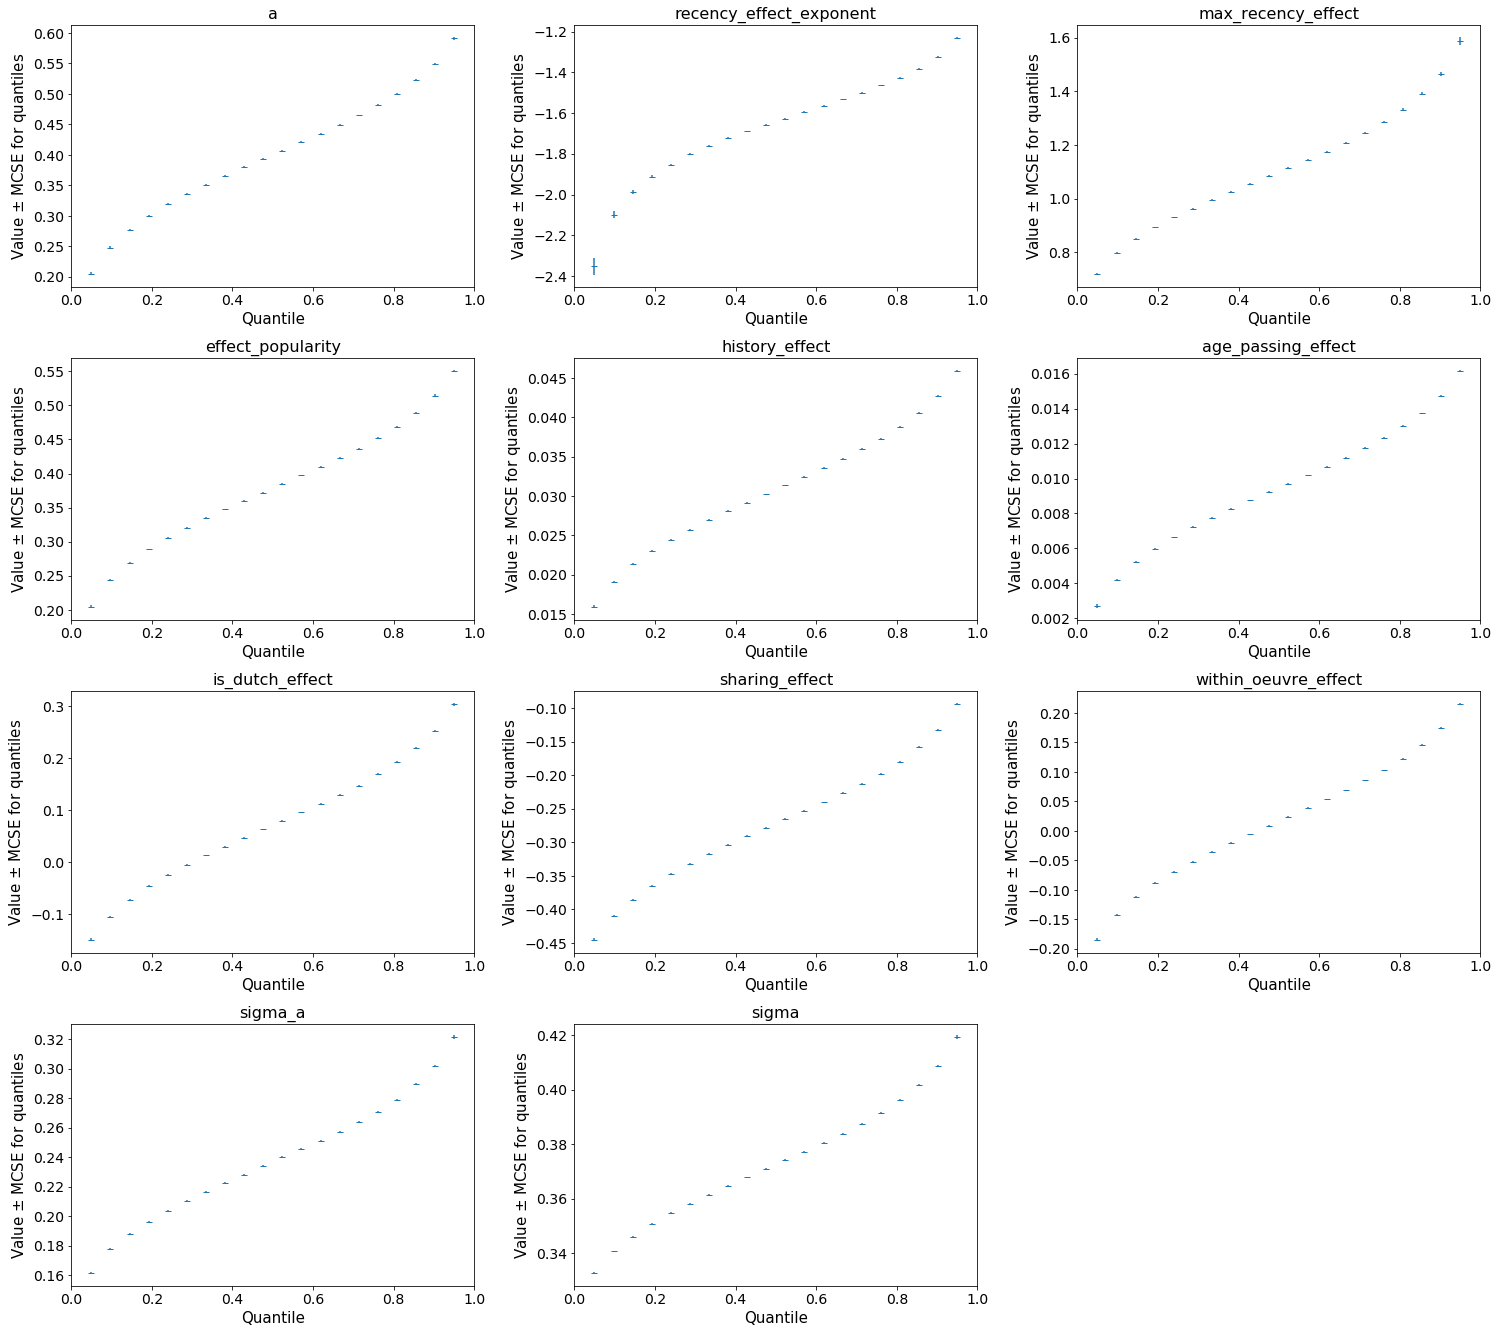

In [77]:
az.plot_mcse(multilevel_noncentered_model_idata, var_names=['~za_artist', '~a_artist', '~mu_artist'], errorbar=True)
plt.show()

Finally, looking at the ESS, we see that it is much smaller at the extremes of all parameters, and mostly so for the recency-related parameters. However, do notice that even for the most extreme quintiles the ESS is much larger than 400, the commonly used boundary

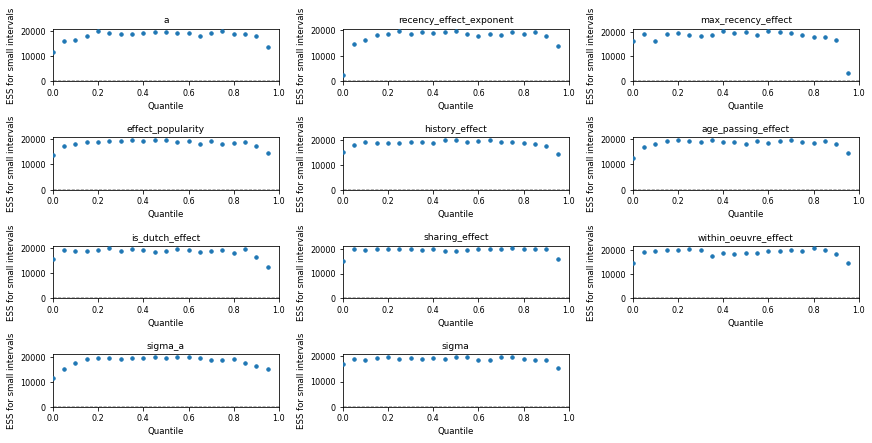

In [78]:
az.plot_ess(multilevel_noncentered_model_idata, var_names=['~za_artist', '~a_artist', '~mu_artist'], figsize=(12, 6), textsize=8)
plt.show()

Small effective sample size can come from three things:
* Short chains
* Low acceptance probability
* High autocorrelation

In our case, we know we have quite long chains, and quite high acceptance probability, so we check that there is autocorrelation. This turns out to be the case, again especially so for the recency-related parameters. This is not ideal, and we could try and lower the autocorrelation for more independent samples, by lowering the acceptance probability (to 80% or 90%, from the current 95%). Doing this, however, turns out to increase the probability of divergences and other signs of bad convergence. So we accept a bit of autocorrelation, and solve this by running larger chains.

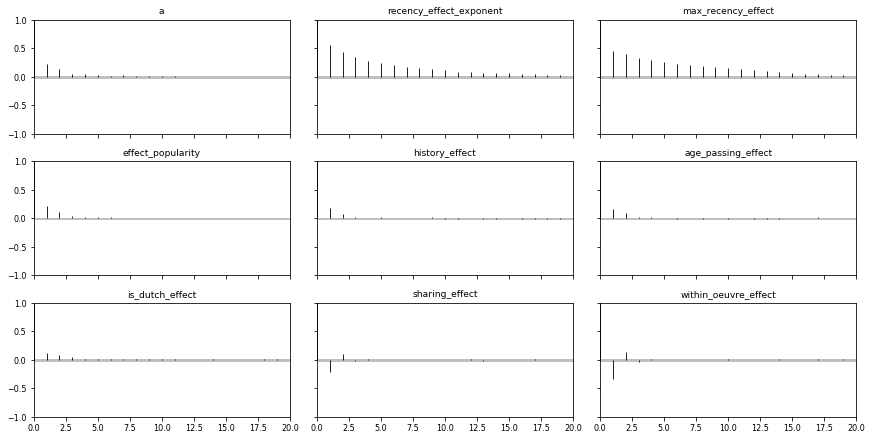

In [79]:
az.plot_autocorr(multilevel_noncentered_model_idata, var_names=var_names, combined=True, max_lag=20, figsize=(12, 6), textsize=8)
plt.show()